# Recommmendation systems

Recommendations system are nowadays widely used in many domains and basically are systems that allow people to get advice on what to use,buy, read, watch etc. In some domains people behaviour are well studied and huge databases are available (like MovieLens for film recommendation domain). In others - not so much. Here, I'll concentrate only on film recommendation domain and will present only a few ideas as well as some challenges that may come with recommendation systems. Nevertheless, there are a lot of resources/books/papers that may be helpful when approaching the topic. Here I'd recommend too books that inspired me into diving deeper. Toby Segaran's "Programming collective intelligence" is a classic book for Machine Learning which presents some basic concepts about collaborative filtering (along with other classical technics for maschine learning). For me it's the best book to grasp basic understandment of the topic. The other is "Recommender Systems - an Introduction" by D. Jannah, M. Zanker, A. Felfernig, G. Friedrich, which presents a great overview of recommender systems and challenges that may appear.

Types of recommender systems:
- Collaborative (to be described in more details)
- Content-based
- Knowledge-based
- Hybrid

The type of recommender system to use is dependendant on the domain. For example for film domain where we have a lot of users and a lot of items collaborative filtering and content-based approaches seems to be appropriate approaches. I'll concentrate here on colaborative filtering approach and present some of the approaches from mentioned earlier "Recommender Systems Introduction" book.

Collaborative filtering uses experiences (here ratings) of other users to find sth to recommend. There are many approaches which can be taken to exploit those experiences.
First to be described here is __"User-based nearest neighbour recommendation"__ where you find other users that are similar to you and recommend sth they liked. There are a few challanges with recommendation system that are to be found here (although most of those are more general). What does it mean "nearest neighbour"? what metrics to choose to measure this? People tend to watch different films and usually only some from many. Also one needs to be carefull with some methods as there is relatively "small number" of ratings in comparison to film and users (In case of described MovieLens datasets we have about 270tho users, 45tho films and 2.6mln ratings. That means that if we wanted to create users x films matrix with ratings in cells only around 0.2% of it would be filled in) and calculating all the users similarity may very expensive computationally (due to size of users x films matrix) and calculating similarity between users may require user x user matrix which is even bigger (on the other hand when calculating recommendations for the specific user (which seems as a common task) we only need to calculate similarieties of this user to other users (without calculating similarieties between other users). Other problem known as "cold start" is when we have a new user that has not yet rated any movies. In such case it may be difficult to assess similarity to other users.

Basing on Movielens dataset I'll try to use _user-based nearest neighbour_ approach to find prediction for randomly chosen 100 ratings (Note, that recommendation problem can be sometimes treated as rating prediction problem or classification problem). This way I'm cutting a bit the computational issue and allow me to do some evaluation on achieved scores. On the other hand some technics used here cannot be directly applied to calculating scores for all users/movies. As a similarity measure I'm going to use pearson correlation using up to 40 nearest neighbours with positive correlation. I'll try to _fill in_ the database one example at a time.

In [2]:
import numpy as np
import pandas as pd

In [3]:
ratings = pd.read_csv('../ratings.csv')
ratings.drop(['timestamp'],axis=1,inplace=True)
#ratings.set_index(['userId','movieId'],inplace=True)
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [4]:
#randomly choosing 100 elements
import random
random100 = [int(ratings.shape[0]*random.random()) for i in range(100)]
org100 = ratings.loc[random100,:]

In [5]:
ratings.drop(random100,axis=0,inplace=True)
ratings.shape

(26024189, 3)

Since I'm going to be predicting ratings rather than doing recommendations it may be worth standarazing results before. This is needed as some people may generally give higher results than others. Standarization will get rid of this effect, but we need to remember to reverse it after calculating the score. Therefore, I'm doing it only based on training set. It will also allow me to remove some odd cases (respondents with low numbers of movies rated, or those giving the same answer to every movie. Standard deviation > 0 should do the trick (it's often that respondents with just a few answers will also have the same for each movie and on the other hand even a few films but with different answers can be either very informative, or will not correlate with users in test set)

In [6]:
ratings_stats=ratings.groupby('userId').rating.agg(['mean','count',lambda u: np.std(u,ddof=0)])
ratings_stats.rename(columns={'<lambda>':'std'},inplace=True)
ratings = ratings.merge(ratings_stats,how='left',left_on='userId',right_index=True)
ratings=ratings[ratings['std']>0.0]
ratings.head(5)

,userId,movieId,rating,mean,count,std
0,1,110,1.0,4.277778,27,1.173262
1,1,147,4.5,4.277778,27,1.173262
2,1,858,5.0,4.277778,27,1.173262
3,1,1221,5.0,4.277778,27,1.173262
4,1,1246,5.0,4.277778,27,1.173262


In [7]:
ratings['rating_std'] = (ratings['rating']-ratings['mean'])/ratings['std']
ratings.drop(['rating','mean','count','std'],axis=1,inplace=True)
ratings.rename(columns={'rating_std':'rating'},inplace=True)
ratings.head(5)

,userId,movieId,rating
0,1,110,-2.793731
1,1,147,0.189405
2,1,858,0.615568
3,1,1221,0.615568
4,1,1246,0.615568


In [14]:
ratings.to_pickle('../training.pkl')
org100.to_pickle('../test.pkl')
ratings_stats.to_pickle('../stats.pkl')

In [4]:
ratings = pd.read_pickle('../training.pkl')
org100 = pd.read_pickle('../test.pkl')
ratings_stats = pd.read_pickle('../stats.pkl')

In [3]:
def calc_score(df,user,movie):
    #helper function for selecting base for the calculation of separate example.
    #I need base of ratings of users that rated the movie and only this movie and movies rated by user 
    #(as other will be removed when calculating correlation anyway)
    users = df[df.movieId==movie].userId.unique()
    df2 = df.loc[df.movieId==movie,['userId','rating']]
    df2.set_index('userId',inplace=True)
    df = df.set_index('movieId')
    #use of set_index inplace=True powoduje zmianę oryginalnej bazy (tu ratings)
    #print(df.index)
    dfu=df[df.userId==user]
    korelacja = []
    ile = []
    #i=0
    #progres=0
    for u in users:
    #    if i/len(users)>=progres:
    #        print(progres*100)
    #        progres+=0.05
    #    i+=1
        s=dfu.merge(df[df.userId==u],how='left',left_index=True,right_index=True)[['rating_x','rating_y']]
        #print(s.head(2))
        korelacja.append(s.corr().iloc[0,1])
        ile.append(sum(s.rating_y.notna()))
    wynik = pd.DataFrame(data={'userId':users,'korelacje':korelacja,'ile':ile})
    wynik = wynik[wynik['korelacje']>0]
    wynik = wynik[wynik['ile']>10].sort_values(by = 'korelacje',ascending=False).head(40)
    wynik.set_index('userId',inplace=True)
    wynik['waga'] = wynik.korelacje/np.sum(wynik.korelacje)
    wynik2 = wynik.merge(df2,how='left',left_index=True,right_index=True)
    wynik2['partial_score'] = wynik2.waga*wynik2.rating
    
    # need to add score
    #a small variation - I'm using correlation for weights as well
    #give back standarized result
    
    return np.sum(wynik2.partial_score)



In [4]:
import time
#@njit(parallel=True)
aa = org100.copy().tail(16)
def calc(org100):
    start = time.time()
    org100['st_rate']=0
    for index,row in org100.iterrows():
        row['st_rate']= calc_score(ratings,int(row['userId']),int(row['movieId']))
        print(index,row['st_rate'])
        print('seconds from start: {}'.format(time.time()-start))
    return org100
calc(aa)




15210541 0.9388358719499397
seconds from start: 3763.1364533901215
17294982 -0.6956192622073253
seconds from start: 3791.918465614319
4587448 0.5486754334027073
seconds from start: 5064.216067075729
25532957 0.47285689356574
seconds from start: 6722.9332501888275
18675184 0.052432186736512766
seconds from start: 7229.9806118011475
9244239 0.02754702759131639
seconds from start: 7250.0584082603455
12140450 -0.28344850894342266
seconds from start: 7417.377404689789
416168 0.6520973061190707
seconds from start: 10602.429420948029
22332928 -1.823083987208077
seconds from start: 10622.073608875275
12087250 -0.43355300798018764
seconds from start: 10626.831299066544
10163109 0.3138325336619543
seconds from start: 12032.383526563644
4475902 0.4063159307365915
seconds from start: 12153.088498830795
4473089 0.012881033341296824
seconds from start: 12701.52581524849
18523323 0.33368830376547876
seconds from start: 13797.84387922287
12729302 0.6360349898407391
seconds from start: 13955.2622525691

NameError: name 'to_pickle' is not defined

In [20]:
predictions = pd.read_csv('../user_18pct.csv')
predictions.set_index('id',inplace=True)
org100_pred = org100.merge(predictions,how='left',left_index=True,right_index=True)
org100_pred.head()

,userId,movieId,rating,prediction
1674419,17381,4442,3.5,-0.669983
12732956,132149,2706,4.0,-0.095552
22947669,238311,2012,3.0,-0.642064
10125422,104441,3753,3.0,-0.080935
13789996,143270,152081,4.0,0.211935


In [21]:
#Destandarizing results
org100_pred = org100_pred.merge(ratings_stats,how='left',left_on='userId',right_index=True)
org100_pred['prediction_final'] = (org100_pred['prediction'] * org100_pred['std'])+org100_pred['mean']
org100_pred['prediction_diff'] = org100_pred['rating'] - org100_pred['prediction_final'] 
org100_pred.head()

,userId,movieId,rating,prediction,mean,count,std,prediction_final,prediction_diff
1674419,17381,4442,3.5,-0.669983,3.608187,1197,0.622765,3.190945,0.309055
12732956,132149,2706,4.0,-0.095552,3.636047,430,0.962423,3.544085,0.455915
22947669,238311,2012,3.0,-0.642064,3.838710,341,0.947491,3.230360,-0.230360
10125422,104441,3753,3.0,-0.080935,3.221477,745,0.907431,3.148034,-0.148034
13789996,143270,152081,4.0,0.211935,3.838308,201,0.537152,3.952150,0.047850


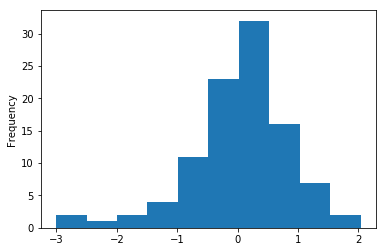

In [23]:
import matplotlib.pyplot as plt
import seaborn as sbs
%matplotlib inline
org100_pred['prediction_diff'].plot.hist()

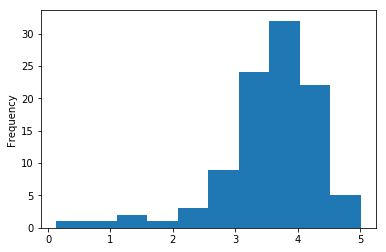

In [24]:
org100_pred['prediction_final'].plot.hist()

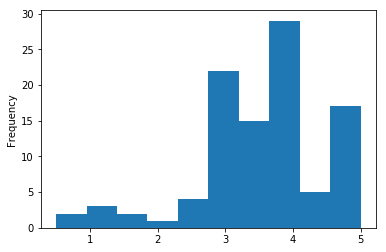

In [25]:
org100_pred['rating'].plot.hist()

In [27]:
org100_pred['prediction_diff2'] = org100_pred['prediction_diff']*org100_pred['prediction_diff']
org100_pred.sort_values(by=['prediction_diff2'],ascending=False).head(20)

,userId,movieId,rating,prediction,mean,count,std,prediction_final,prediction_diff,prediction_diff2
4475902,46015,3451,1.0,0.406316,3.571210,653,1.068796,4.005479,-3.005479,9.032903
17986423,186784,2571,0.5,-0.023679,3.239583,48,1.651986,3.200466,-2.700466,7.292516
6095165,62770,1721,1.5,-0.059756,3.645022,231,0.895858,3.591488,-2.091488,4.374324
25739134,267855,196,3.5,-1.066716,2.800000,35,1.254705,1.461586,2.038414,4.155133
23242031,241183,1285,1.0,-0.295869,3.089810,579,1.244907,2.721481,-1.721481,2.963498
1300837,13301,2196,3.0,-1.269914,2.926667,450,1.170546,1.440174,1.559826,2.433058
8150102,83995,1923,2.0,-0.046525,3.551136,88,0.866156,3.510839,-1.510839,2.282634
39886,431,303,5.0,-0.578016,4.025316,79,0.728701,3.604116,1.395884,1.948493
15210541,158279,318,5.0,0.938836,3.033113,151,0.675172,3.666988,1.333012,1.776920
21803529,226474,1721,5.0,-0.045005,3.770186,322,0.857908,3.731577,1.268423,1.608898


In [28]:
org100_pred[org100_pred['prediction_diff2']<=.25].shape

(53, 10)

In [31]:
sum((org100_pred['rating']-3.5)*(org100_pred['rating']-3.5)<=0.25)

66

Some variations to the results are to be expected as ratings are discrete (can change only by 0.5) and predictions are continuous. However, results are not that great. And it took about 24 hours to calculate it. As for quality only 53 out 100 had prediction that were diviating from real rating by not more than 0.5. In comparison it would be 66 cases if we were to predict 3.5 for all (3.52 is mean of all ratings for all films), so it actually works worse than benchmark when it comes to prediction. But unlike benchmark it can rank results, which is actually what's required from this task. Some ways to improve performance would be to change some parameters (like for example how many nearest neighbours to account for or using different similarity metric). The running time of the algorithm can be cut by calculating the whole similarity (correlation) matrix and the just accessing what's needed, but that needs a lot of memory space (note that there are over 260000 users and over 45000 (which is not unusual for recommendation systems), so the matrix of rating will be bigger than 45000x260000 and the correlation matrix greater than 260000x260000). Also even doing what I'm doing here could probably work faster, as the algorithm is written in better way or parallel computing is applied.

[back](part4.ipynb) [index](index.ipynb)